In [1]:
from pathlib import Path
import re
import pandas as pd
import plotly.express as px
import plotly.io as pio

## Ontonotes NER detection performance

In [2]:
ONTO_RESULTS_DIR = Path('ontonotes')
summary= pd.read_csv(ONTO_RESULTS_DIR / 'summary.txt', sep='\t')

Check which models did not work, and exclude them from further analysis:

In [3]:
bad_performers = summary.loc[summary['F1-Macro'] < 0.1, 'Model']
bad_performers.tolist()

['bert-char-ner',
 'bert-glove-ner',
 'finbert-char-ner',
 'finbert-glove-ner',
 'finbert-roberta-ner']

In [4]:
summary = summary[~pd.isnull(summary['F1-Macro']) & (summary['F1-Macro'] > 0.1)]   # Skip bad performers
summary['Time'] = pd.to_datetime(summary['Ended']) - pd.to_datetime(summary['Started'])
summary.sort_values(by='F1-Macro', ascending=False)

Model                  Started                    Ended  \
3         elmo-ner  2021-04-08 00:24:59,885  2021-04-08 10:03:48,279   
2         bert-ner  2021-04-02 10:21:49,324  2021-04-02 18:09:16,504   
9        flair-ner  2021-03-31 10:21:16,126  2021-03-31 18:31:59,977   
11     roberta-ner  2021-04-08 10:03:48,304  2021-04-08 20:35:26,710   
13       xlnet-ner  2021-04-08 00:35:57,303  2021-04-08 11:26:51,042   
10  glove-char-ner  2021-04-01 17:57:50,892  2021-04-02 22:13:36,538   
7      finbert-ner  2021-03-27 01:57:55,744  2021-03-27 12:03:04,319   

    F1-Micro  F1-Macro                   Time  
3     0.8530    0.7473 0 days 09:38:48.394000  
2     0.8453    0.7408 0 days 07:47:27.180000  
9     0.8464    0.7397 0 days 08:10:43.851000  
11    0.8426    0.7315 0 days 10:31:38.406000  
13    0.8367    0.7204 0 days 10:50:53.739000  
10    0.8279    0.7017 1 days 04:15:45.646000  
7     0.7859    0.6374 0 days 10:05:08.575000

In [5]:
perf = pd.read_csv(ONTO_RESULTS_DIR / 'perf.txt', sep='\t', header=None)
perf.columns = ['Model', 'Type', 'Result']

In [6]:
def parse_number(str_, fun=int):
    try:
        return fun(str_)
    except ValueError:
        return None

def extract_metrics(entry):
    entry = entry['Result']
    match = re.search('tp: (\d+) - fp: (\d+) - fn: (\d+) - precision: (.*) - recall: (.*) - f1-score: (.*)', entry)
    if match:
        return (parse_number(match.group(1)), parse_number(match.group(2)), parse_number(match.group(3)),
                parse_number(match.group(4), fun=float), parse_number(match.group(5), fun=float),
                parse_number(match.group(6), fun=float))
    else:
        return (tuple([None]*6))

In [7]:
perf[['TP', 'FP', 'FN', 'Precision', 'Recall', 'F1-Score']] = perf[['Result']].apply(extract_metrics, axis=1, result_type="expand")
perf = perf.drop(labels='Result', axis=1)

In [8]:
perf.loc[~perf['Model'].isin(bad_performers), ['Model', 'Type', 'Precision', 'F1-Score']].pivot(index='Type', columns='Model')
# perf[['Model', 'Type', 'Precision', 'F1-Score']].pivot(index='Type', columns='Model')

Precision                                                \
Model        bert-ner elmo-ner finbert-ner flair-ner glove-char-ner   
Type                                                                  
CARDINAL       0.7629   0.7754      0.7413    0.7655         0.7539   
DATE           0.7968   0.7896      0.7663    0.7969         0.7759   
EVENT          0.5349   0.5682      0.4930    0.5281         0.6129   
FAC            0.6822   0.6903      0.5269    0.7075         0.6222   
GPE            0.8826   0.8875      0.8521    0.8911         0.8803   
LANGUAGE       0.9000   0.8000      0.5556    0.8889         0.7273   
LAW            0.5814   0.5111      0.4231    0.6053         0.5385   
LOC            0.6157   0.6770      0.6268    0.7212         0.6739   
MONEY          0.8753   0.8691      0.8575    0.8618         0.8496   
NORP           0.8190   0.8668      0.7834    0.8570         0.8412   
ORDINAL        0.6519   0.6867      0.5946    0.6914         0.6667   
ORG            0.7997   0.8412      0.7583    0.8235         0.8019   
PERCENT        0.8605   0.8643      0.8507    0.8623         0.8571   
PERSON         0.8805   0.8853      0.8155    0.8660         0.8553   
PRODUCT        0.6479   0.7105      0.7442    0.7313         0.6613   
QUANTITY       0.7361   0.7557      0.7073    0.7597         0.6439   
TIME           0.5802   0.5982      0.5391    0.6056         0.5575   
WORK_OF_ART    0.6855   0.7343      0.6596    0.6429         0.6207   

                                  F1-Score                                 \
Model       roberta-ner xlnet-ner bert-ner elmo-ner finbert-ner flair-ner   
Type                                                                        
CARDINAL         0.7703    0.7471   0.8059   0.7998      0.7595    0.7847   
DATE             0.7882    0.7838   0.8461   0.8278      0.8086    0.8391   
EVENT            0.6163    0.6145   0.5380   0.5780      0.4487    0.5402   
FAC              0.6406    0.6981   0.6400   0.6023      0.4100    0.5952   
GPE              0.8897    0.8927   0.9101   0.9139      0.8644    0.9104   
LANGUAGE         0.7778    0.5385   0.7500   0.6667      0.4348    0.6957   
LAW              0.4348    0.5897   0.5747   0.5169      0.3143    0.5610   
LOC              0.6352    0.6883   0.6351   0.6939      0.6179    0.7092   
MONEY            0.8568    0.8611   0.9010   0.8826      0.8780    0.8870   
NORP             0.8176    0.8792   0.8521   0.8877      0.8038    0.8747   
ORDINAL          0.6838    0.6838   0.7521   0.7651      0.7126    0.7619   
ORG              0.8250    0.8161   0.8303   0.8688      0.7411    0.8525   
PERCENT          0.8491    0.8561   0.8824   0.8832      0.8714    0.8750   
PERSON           0.8660    0.8431   0.9033   0.8980      0.8207    0.8881   
PRODUCT          0.6667    0.6393   0.5860   0.6667      0.4961    0.6405   
QUANTITY         0.7381    0.7687   0.7138   0.6972      0.6304    0.6950   
TIME             0.6396    0.6000   0.6337   0.6291      0.5741    0.6217   
WORK_OF_ART      0.6842    0.5507   0.5802   0.6731      0.2870    0.5825   

                                                  
Model       glove-char-ner roberta-ner xlnet-ner  
Type                                              
CARDINAL            0.7810      0.7976    0.7724  
DATE                0.8170      0.8235    0.8235  
EVENT               0.5170      0.6199    0.6071  
FAC                 0.4746      0.5985    0.5873  
GPE                 0.9021      0.9158    0.9124  
LANGUAGE            0.6400      0.6087    0.5185  
LAW                 0.5060      0.4444    0.5542  
LOC                 0.6966      0.6607    0.7130  
MONEY               0.8628      0.8830    0.8757  
NORP                0.8664      0.8475    0.8846  
ORDINAL             0.7506      0.7672    0.7672  
ORG                 0.8176      0.8485    0.8344  
PERCENT             0.8759      0.8717    0.8789  
PERSON              0.8777      0.8870    0.8687  
PRODUCT             0.5541      0.6

## Training performance (Ontonotes)

In [9]:
loss = pd.read_csv(ONTO_RESULTS_DIR / 'loss.txt', sep='\t')

In [10]:
loss = loss[~loss['MODEL'].isin(bad_performers)]
loss.head()

MODEL  EPOCH TIMESTAMP  BAD_EPOCHS  LEARNING_RATE  TRAIN_LOSS  \
152  bert-ner      1  10:59:09           0            0.1    3.243741   
153  bert-ner      2  11:05:14           0            0.1    2.419580   
154  bert-ner      3  11:12:00           0            0.1    2.079040   
155  bert-ner      4  11:18:05           0            0.1    1.926559   
156  bert-ner      5  11:24:12           0            0.1    1.824913   

      DEV_LOSS  DEV_PRECISION  DEV_RECALL  DEV_F1  
152  21.041252         0.0000      0.0000  0.0000  
153   1.668556         0.8193      0.8415  0.8303  
154   1.589544         0.8230      0.8444  0.8336  
155   1.483879         0.8235      0.8599  0.8413  
156   1.456725         0.8263      0.8611  0.8433

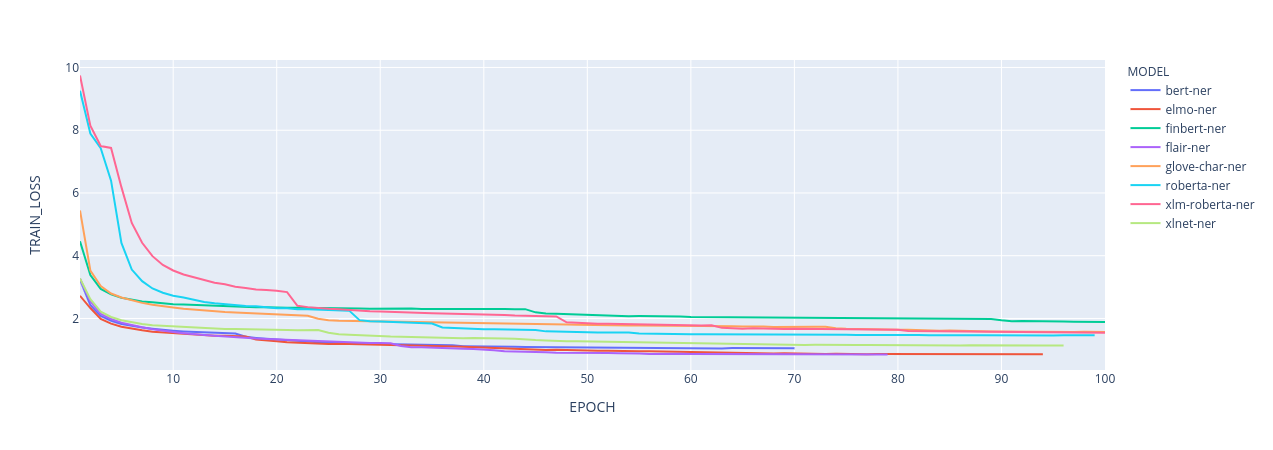

In [11]:
px.line(loss, x="EPOCH", y="TRAIN_LOSS", color='MODEL')

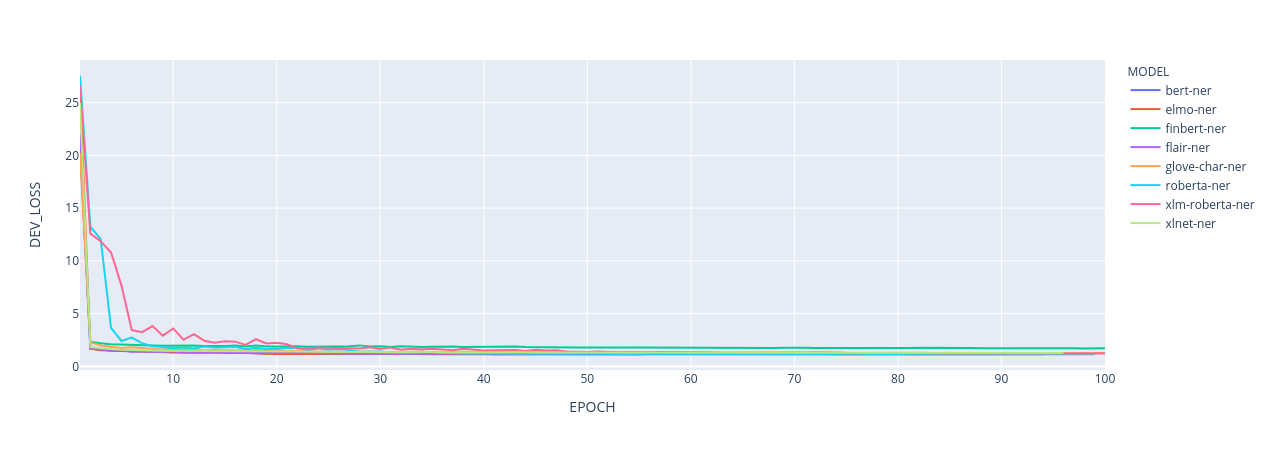

In [12]:
fig = px.line(loss, x="EPOCH", y="DEV_LOSS", color='MODEL')
pio.write_html(fig, file=str(Path('graphs') / 'valid_loss_onto_32.html'))
fig.show()

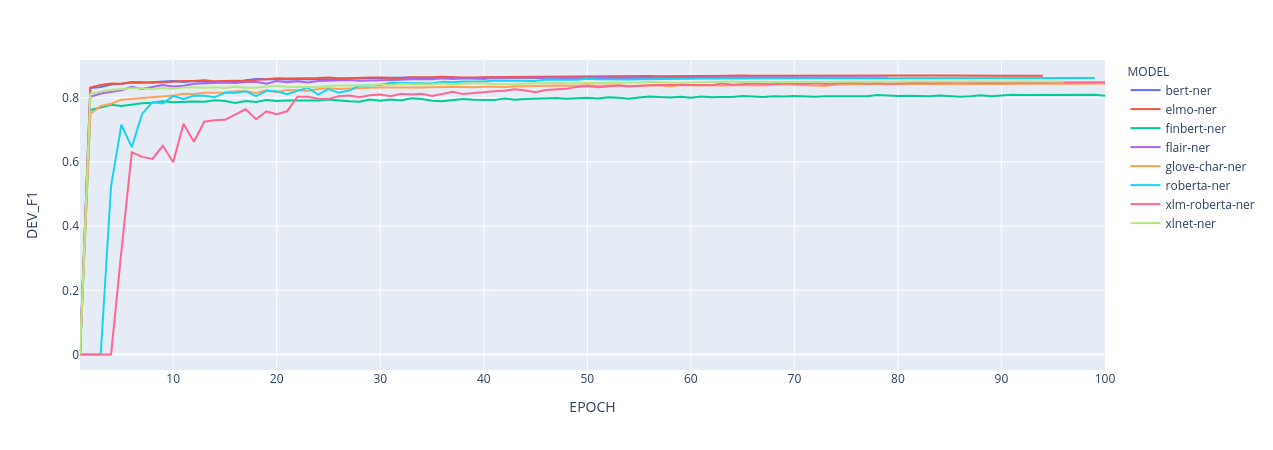

In [13]:
px.line(loss, x="EPOCH", y="DEV_F1", color='MODEL')

## SEC NER detection performance

In [14]:
SEC_RESULTS_DIR = Path('sec')
summary= pd.read_csv(SEC_RESULTS_DIR / 'summary.txt', sep='\t')

Check which models did not work, and exclude them from further analysis:

In [15]:
bad_performers = summary.loc[summary['F1-Macro'] < 0.1, 'Model']
bad_performers.tolist()

['finbert-char-ner', 'glove-char-ner']

In [16]:
summary = summary[~pd.isnull(summary['F1-Macro']) & (summary['F1-Macro'] > 0.1)]   # Skip bad performers
summary['Time'] = pd.to_datetime(summary['Ended']) - pd.to_datetime(summary['Started'])
summary.sort_values(by='F1-Micro', ascending=False)

Model                  Started                    Ended  F1-Micro  \
5  roberta-ner  2021-04-12 23:13:42,272  2021-04-12 23:23:11,570    0.8206   
2  finbert-ner  2021-04-12 22:58:19,976  2021-04-12 23:06:04,991    0.8143   
7    xlnet-ner  2021-04-12 23:23:11,619  2021-04-12 23:31:01,871    0.8143   
3    flair-ner  2021-04-12 23:06:05,134  2021-04-12 23:12:52,549    0.7987   
0     elmo-ner  2021-04-12 23:05:36,980  2021-04-12 23:13:42,244    0.7857   

   F1-Macro            Time  
5    0.6360 00:09:29.298000  
2    0.5800 00:07:45.015000  
7    0.5293 00:07:50.252000  
3    0.5275 00:06:47.415000  
0    0.5982 00:08:05.264000

In [17]:
perf = pd.read_csv(SEC_RESULTS_DIR / 'perf.txt', sep='\t', header=None)
perf.columns = ['Model', 'Type', 'Result']
perf[['TP', 'FP', 'FN', 'Precision', 'Recall', 'F1-Score']] = perf[['Result']].apply(extract_metrics, axis=1, result_type="expand")
perf = perf.drop(labels='Result', axis=1)
perf.loc[~perf['Model'].isin(bad_performers), ['Model', 'Type', 'Precision', 'F1-Score']].pivot(index='Type', columns='Model')

Precision                                             F1-Score  \
Model   elmo-ner finbert-ner flair-ner roberta-ner xlnet-ner elmo-ner   
Type                                                                    
LOC       0.5000      0.5217    0.7931      0.5208    0.5435   0.5476   
MISC      1.0000      1.0000    0.0000      1.0000    0.0000   0.4444   
ORG       0.3605      0.6042    0.4559      0.4684    0.5484   0.4397   
PERSON    0.9610      0.9159    0.9216      0.9614    0.9502   0.9610   

                                                    
Model  finbert-ner flair-ner roberta-ner xlnet-ner  
Type                                                
LOC         0.5714    0.6866      0.5814    0.5952  
MISC        0.2500    0.0000      0.4444    0.0000  
ORG         0.5631    0.5041      0.5522    0.5812  
PERSON      0.9356    0.9193      0.9660    0.9409

## Training performance (SEC)

In [18]:
loss = pd.read_csv(SEC_RESULTS_DIR / 'loss.txt', sep='\t')
loss = loss[~loss['MODEL'].isin(bad_performers)]

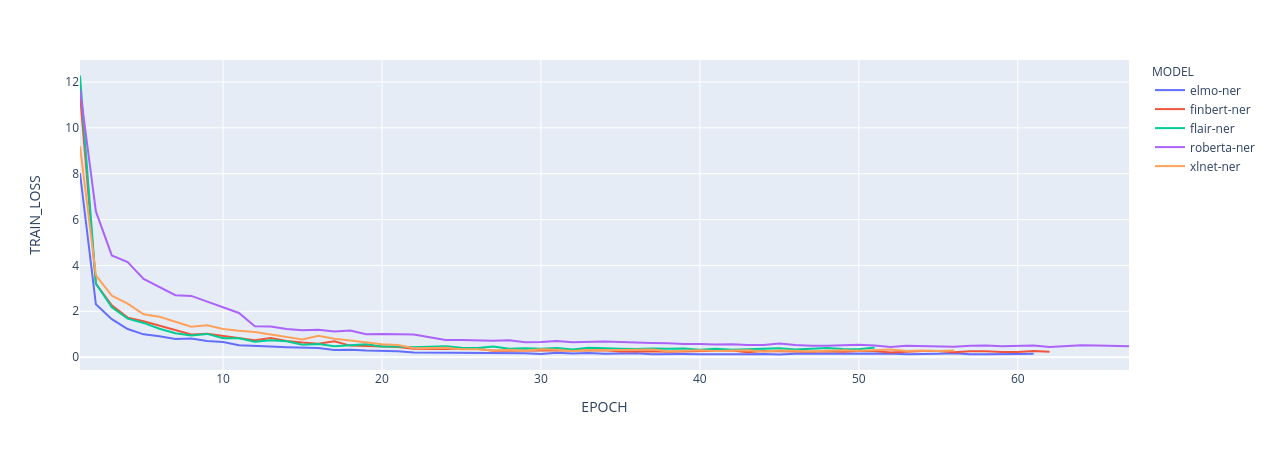

In [19]:
px.line(loss, x="EPOCH", y="TRAIN_LOSS", color='MODEL')

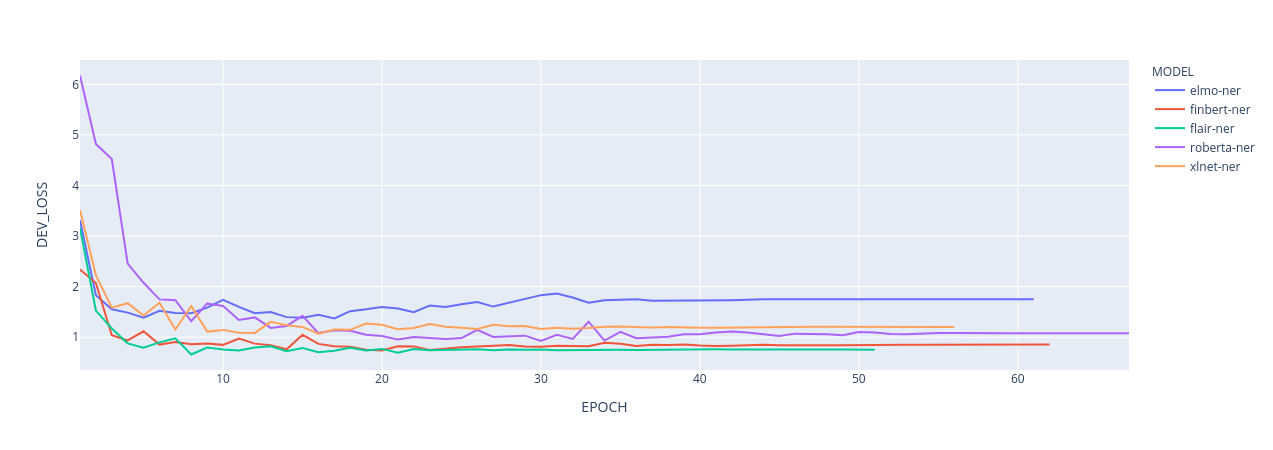

In [20]:
fig = px.line(loss, x="EPOCH", y="DEV_LOSS", color='MODEL')
pio.write_html(fig, file=str(Path('graphs') / 'valid_loss_sec_32.html'))
fig.show()

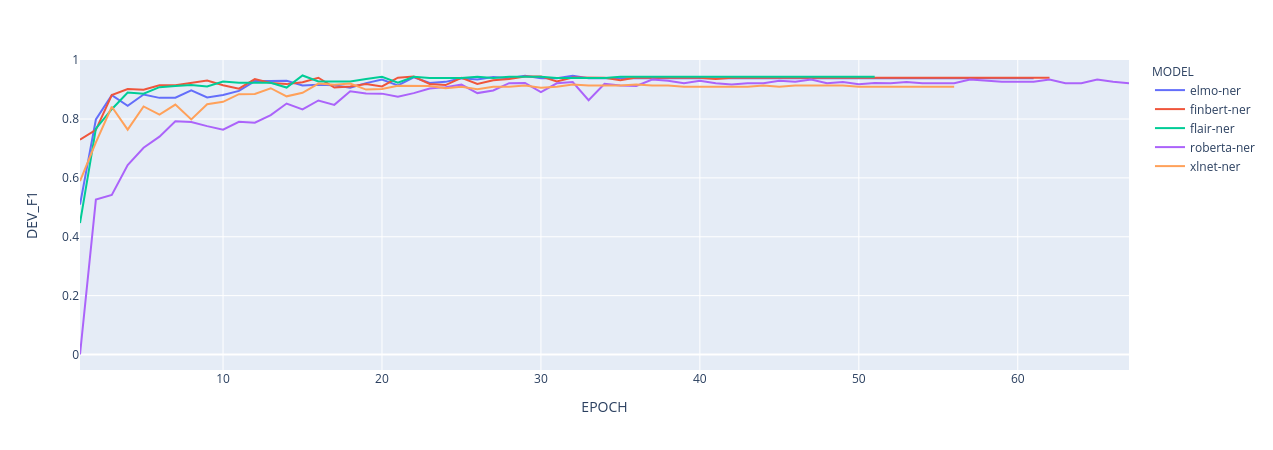

In [21]:
px.line(loss, x="EPOCH", y="DEV_F1", color='MODEL')